In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_old as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# All the parameters
lastfile = 'NeshData/continuum_model6 5-7-2022[2][10].npz'; Load_old_file = True
nextfile = 'NeshData/continuum_model6 5-6-2022[1][11].npz'; Save_new_file = False
trajfile = 'NeshData/continuum_model6 5-6-2022[1][11].traj.npz'; trajflag = False
traj0flag = False

In [4]:
# Number of iterations to calculate Nliq from Ntot
niter = 1

# Loading/initializing state
if not Load_old_file:

    # Message
    print("Starting a new system")
    nx = 500 # Number of points in simulation box
    xmax = 50
    #xmax = 20
    x = np.linspace(0, xmax, nx)
    boxpoints = len(x)
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K
    Nstar = .9/(2*np.pi)
    #Nstar = .55/(2*np.pi)

    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.zeros(boxpoints)+1
    Fliq = ds.getNliq(Nice,Nstar,Nbar,niter) # mess it up here, e.g double thickness in random spot/area
    splitPoint = math.floor(len(Fliq)/2)
#     Fliq[0:splitPoint] *= 1.5 # first half of fliq increased by 50% thickness

else:
    
    # Message
    print("loading", lastfile)
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    boxpoints = len(x)
    nx = len(x)
    deltaX = x[1]-x[0]
    

loading NeshData/continuum_model6 5-7-2022[2][10].npz


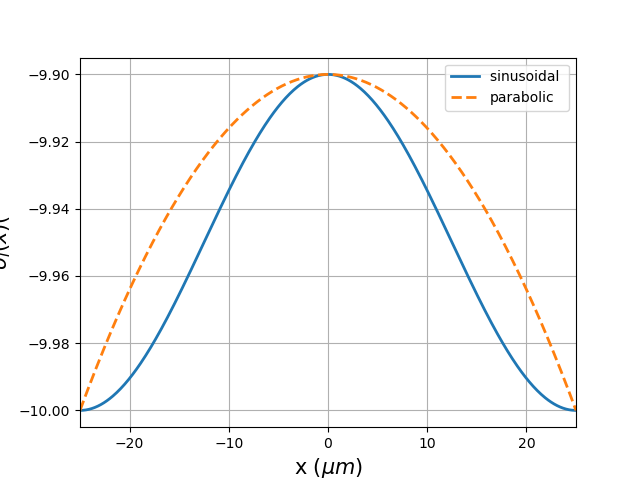

In [5]:
# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = -.1 # Must be bigger than sigma0 to get growth, or less than zero to get ablation
center_reduction = 1 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid')
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# # Graph sigma(x)
# fignum +=1
# plt.figure(fignum)
# plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
#          x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
# plt.xlim([-xmid,xmid])
# plt.legend(['sinusoidal ', 'parabolic'])
# plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
# plt.grid('on')


# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid*100, \
         x-xmid, sigmastep_parabolic*100, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) (%)$',fontsize=fontsize)
plt.grid('on')

In [6]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 5
else:
    countermax_0D = 300

# 1D run 
if uselayers:
    layermax_1D = 10
else:
    countermax_1D = 15000

In [7]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltaT_max (Diffusion time)', dtmax)
print('deltaT =', deltaT)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.20060160400962
deltaT = 1.0040120320801924
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.10020040080160321
sigma_0 = 0.19
sigmastepmax = -0.1
center reduction 1 %
max growth rate = -4.9 um/sec
min growth rate = -14.210000000000003 um/sec
nu_kin = 49 um/sec


breaking because reached max number of layers ablated
0-D Modeled growth rate, um/s -7.797930167676832
0-D Modeled growth rate, ml/us -0.02599310055892277
0-D Modeled alpha 1.5914143199340471


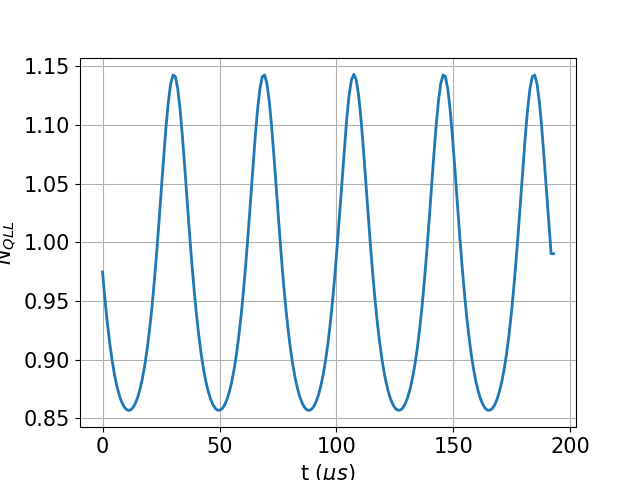

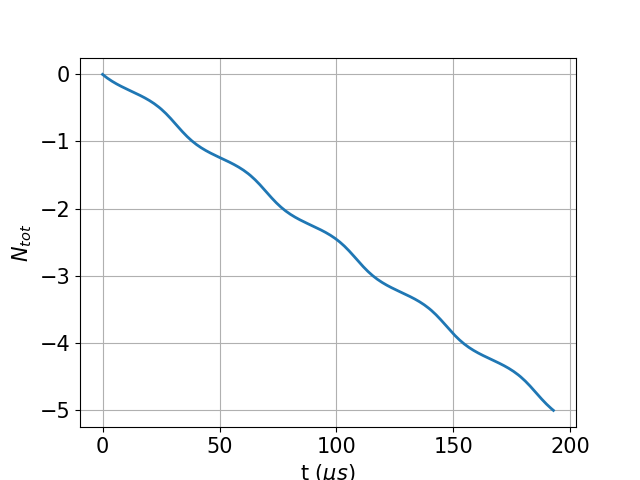

In [8]:
# This is the 0-d run

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastepmax, sigma0, deprate]

# Initial conditions for ODE solver
y0 = [Nbar, 0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast
    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters
    counter += 1
    layer = dup(Ntotlast0) 
    
    # See whether to break
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_0D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_0D:
                print('breaking because reached max number of layers ablated')
                break
            
    else:
        if counter > countermax_0D-1:
            break

    # Report progress, maybe
    # print('finished with ', layer, counter)
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,1],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{tot} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

In [9]:
# Exploring the predictor for the number of layers needed to reach steady state
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # dimensionless
print(D) # D is in micrometers^2/microsecond

if sigmastepmax > 0:
    # Growth conditions
    M = np.array([.0027, .0025])
    B = np.array([2.9, 1.59])
    beta = np.array([0.65, 0.65])
    xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
    NSS = M*xfactor + B
    print('Nss predicted')
    print('sinusoid:', NSS[0])
    print('paraboloic:', NSS[1])
else:
    print('No predictor specified')

25.0
0.01
0.16333333333333333
-0.1
0.0002
No predictor specified


In [10]:
# This is the 1-d run

# Timing
sec1 = time.time()

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

# Initial conditions for ODE solver
y0 = list((Fliq,Ntot))
ylast = dup(y0)

# Time steps
t0 = 0.0
tlast = dup(t0)
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True
counter = 0
lastlayer = 0
lastdiff = 0
while True:

    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT

    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)

    # Update counters
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    
    # Report, maybe
    if np.mod(counter,500) == 0:
        if uselayers:
            if sigmastepmax > 0:
                progress = layer/(layermax_1D-1)
            else:
                progress = -layer/layermax_1D
            print('Layer progress (%): ', progress*100)
        
        else:
            progress = counter/(countermax_1D-1)
            print('Counter progress (%): ', progress*100)

            
    # Test whether we're finished
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_1D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_1D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

breaking because reached max number of layers ablated


Growth ratio 1D (corner)/0D 0.9935456550321542
Growth ratio 1D (center)/0D 0.9930177837298368
Time taken: 0 min 9.736265182495117 secs


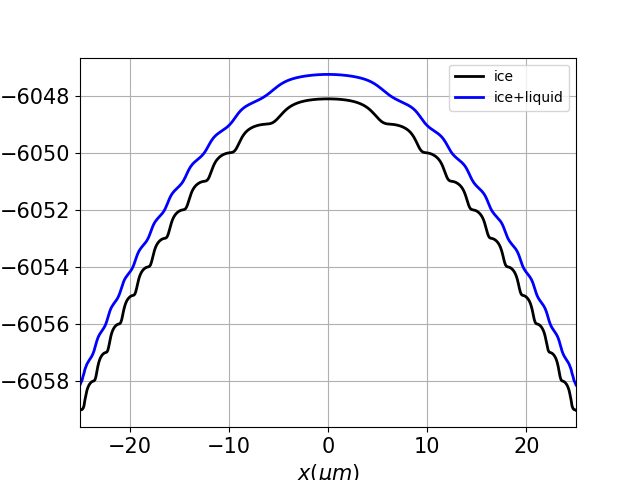

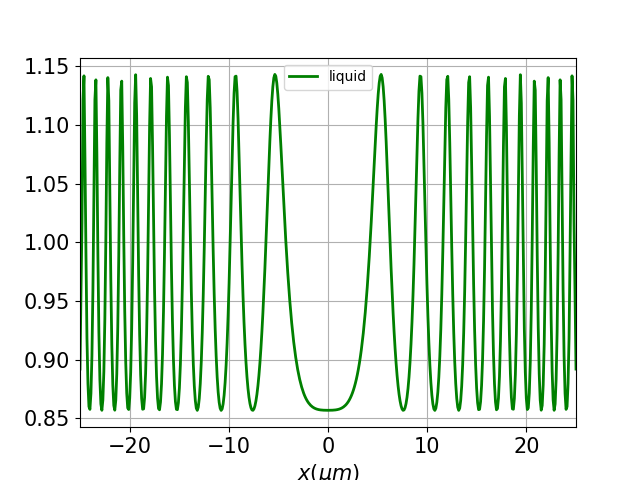

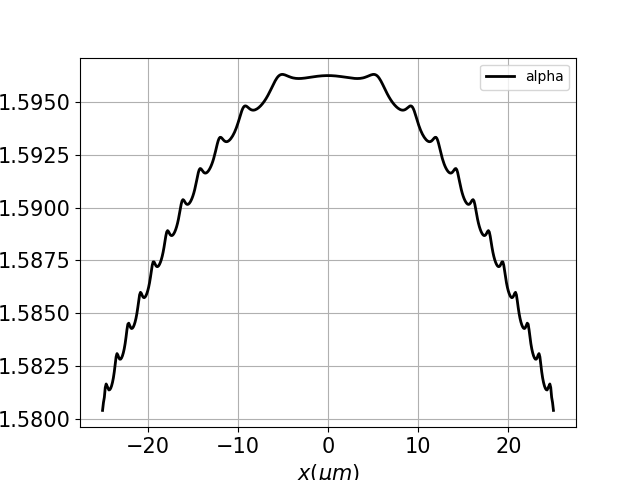

In [11]:
# Growth statistics
# minpoint = min(Nice)
minpoint = 0
ncorner = 4
# print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
# print( "1-D growth, corner", delta_Ntot_entire[ncorner])
# print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
# print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
# print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
# print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
# print( "1-D Modeled alpha, corner", alpha[ncorner])
# print( "1-D Modeled alpha, center", alpha[nmid])
# print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with 0-D model
# print( "0-D Modeled growth rate, um/s", growthrate_0d)
# print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
# print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
# print( "Contribution of diffusion (corner)", (growthrate_entire[ncorner]-growthrate_0d)/growthrate_0d*100, '%')
# print( "Contribution of diffusion (center)", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
# print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
# print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', label='alpha', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

In [12]:
# Saving these results to file
print(Nice[0])
if Nice[0] > 100000: 
    Nice -= 100000
if Save_new_file:
    print("saving to ", nextfile)
    np.savez_compressed(nextfile, Nice=Nice, Fliq=Fliq, 
                        x=x, t=ttot,
                        Nbar=Nbar, Nstar=Nstar,
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


-6059.027941797737


In [13]:
if trajflag:
    print("saving to ", trajfile)
    np.savez_compressed(trajfile, Nice=Nicekeep, Fliq=Fliqkeep,
                        x=x, t=tkeep, 
                        Nbar=Nbar, Nstar=Nstar,
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


In [14]:
if traj0flag:
    print("saving to ", traj0file)
    np.savez_compressed(traj0file, ykeep_0Darr=ykeep_0Darr,
                        x=x, tkeep_0D=tkeep_0D,  
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle,
                        dtmaxtimefactor = dtmaxtimefactor,
                        deltaT = deltaT)
